In [1]:
import os
import numpy as np
import seaborn as sns # for plots
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats as ss # to calcualte confidence intervals, etc
from adjustText import adjust_text # to adjust the text labels in the plots (pip install adjustText)
from scipy.stats import ttest_rel 
from statsmodels.stats.anova import AnovaRM # perform F test

import cortico_cereb_connectivity.globals as gl
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import selective_recruitment.data as sd
import selective_recruitment.regress as sr
import selective_recruitment.plotting as sp


## Global comparison of MDTB conditions in cortex and cerebellum

In [2]:
Y,X,info=sd.get_voxdata_cereb_cortex(dataset='MDTB',ses_id='all')

In [3]:
# Aggregate into the standard data frame for selective recruitment
n_subj = X.shape[0  ]
vec = np.ones((len(info),))
summary_list = []
labels, info['cond_num_uni'] = np.unique(info.cond_name,return_inverse=True)
for i in range(n_subj):
    info_sub = pd.DataFrame({"sn": i * vec,
            "roi": 1 * vec,
            "X":  np.nanmean(X[i,:,:],axis=1),
            "Y":  np.nanmean(Y[i,:,:],axis=1),
            "cond_name": info["cond_name"],
            "cond_num_uni": info["cond_num_uni"],
            "sess": info["sess"]})
    summary_list.append(info_sub)
T= pd.concat(summary_list,ignore_index=True)


In [4]:
T = sr.roi_regress(T,fit_intercept = True)

/Users/jdiedrichsen/Python/selective_recruitment/plotting.py:114: UserWarning: 
The markers list has fewer values (1) than needed (47) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(data=df, x='X', y='Y', style = split, hue = split, s = 100,legend=None,markers=markers,palette=colors)


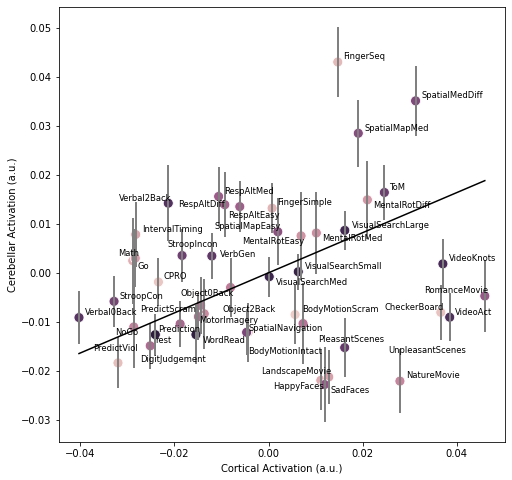

In [9]:
plt.figure(figsize=(8,8))
sp.make_scatterplot(T, split='cond_num_uni',labels = 'cond_name')
plt.savefig('MDTB_all.pdf',dpi=300,bbox_inches='tight')

In [6]:
# prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df_residuals ,groupby = "cond_name", agg_kw=agg_kw)


NameError: name 'prep_df' is not defined

In [ ]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [ ]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=df_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

# ROI based analysis (WordRead-MDTB roi)

In [ ]:
rdf_path = os.path.join(conn_dir, "IBC", "sc_IBC_ses-rsvplanguage_WordRead.tsv")
rdf = pd.read_csv(rdf_path, sep="\t")
rdf = rdf[rdf['cond_name'] != 'probe']

rdf_averaged = rdf.groupby(['sn', 'cond_name']).mean()
rdf_averaged = rdf_averaged.drop(columns=['half','res','coef','R2'])
rdf_averaged = rdf_averaged.reset_index()
rdf_averaged


In [ ]:
rdf_residuals = rdf_averaged.copy()

#create new columns to store the slope and intercept
rdf_residuals['slope'] = np.nan
rdf_residuals['intercept'] = np.nan

#group the dataframe by sn
r_sn_groups = rdf_residuals.groupby(['sn'])

#calculate slope and intercept for each subject
for name, group in r_sn_groups:
    # fit linear reg model
    slope, intercept = np.polyfit(group['X'], group['Y'], 1)
    # save values
    rdf_residuals.loc[rdf_residuals['sn'] == name, 'slope'] = slope
    rdf_residuals.loc[rdf_residuals['sn'] == name, 'intercept'] = intercept

# calcualte each res
for index, row in rdf_residuals.iterrows():

    Y_pred = row['slope'] * row['X'] + row['intercept']

    res = row['Y'] - Y_pred

    rdf_residuals.loc[index, 'Y_pred'] = Y_pred
    rdf_residuals.loc[index, 'res'] = res


plt.figure(figsize=(10, 5))
sns.barplot(data=rdf_residuals,x='cond_name',y='res', order=['consonant_string', 'pseudoword_list', 'jabberwocky', 'word_list', 'simple_sentence', 'complex_sentence'])

In [ ]:
#prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
rdf_preped = prep_df(rdf_residuals ,groupby = "cond_name", agg_kw=agg_kw)

In [ ]:
make_plot(rdf_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [ ]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=rdf_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

# CONNECTIVITY MDTB-S1

In [ ]:
# load the dataframe for the whole 
cdf_path = os.path.join(conn_dir, "IBC", "sc_conn_MDTB_IBC_ses-rsvplanguage_WordRead.tsv")
cdf = pd.read_csv(cdf_path, sep="\t")
cdf = cdf[cdf['cond_name'] != 'probe']

cdf_averaged = cdf.groupby(['sn', 'cond_name']).mean()
cdf_averaged = cdf_averaged.drop(columns=['half','res','coef','R2'])
cdf_averaged = cdf_averaged.reset_index()
cdf_averaged

In [ ]:
cdf_residuals = cdf_averaged.copy()

#create new columns to store the slope and intercept
cdf_residuals['slope'] = np.nan
cdf_residuals['intercept'] = np.nan

#group the dataframe by sn
c_sn_groups = cdf_residuals.groupby(['sn'])

#calculate slope and intercept for each subject
for name, group in c_sn_groups:
    # fit linear reg model
    slope, intercept = np.polyfit(group['X'], group['Y'], 1)
    # save values
    cdf_residuals.loc[cdf_residuals['sn'] == name, 'slope'] = slope
    cdf_residuals.loc[cdf_residuals['sn'] == name, 'intercept'] = intercept

# calcualte each res
for index, row in cdf_residuals.iterrows():

    Y_pred = row['slope'] * row['X'] + row['intercept']

    res = row['Y'] - Y_pred

    cdf_residuals.loc[index, 'Y_pred'] = Y_pred
    cdf_residuals.loc[index, 'res'] = res


plt.figure(figsize=(10, 5))
sns.barplot(data=cdf_residuals,x='cond_name',y='res')

In [ ]:
#prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
cdf_preped = prep_df(cdf_residuals ,groupby = "cond_name", agg_kw=agg_kw)

In [ ]:
make_plot(cdf_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [ ]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=cdf_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())